Setup

In [1]:
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import csv
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.models import load_model
from keras_visualizer import visualizer
import visualkeras
from keras.utils.vis_utils import plot_model
from PIL import ImageFont

Parsing the data

In [2]:
text_pairs =[]
csvfile = open('dataset/r-urdu-to-eng-final.csv',newline='')
reader = csv.DictReader(csvfile)
for row in reader:
    text_pairs.append((row['Roman Urdu'],"[start] " + row['English'] + " [end]"))


In [3]:
for _ in range(5):
    print(random.choice(text_pairs))

('aam unka sabse pasandida phal hai lekin nashpati mera sabse pasandida phal hai', '[start] the mango is their most loved fruit but the pear is my most loved [end]')
('usny ahsan pr jadu krdiya ha', '[start] he has put a spell on ahsan [end]')
('maa pyari maa very nice', '[start] mother beautiful mother very nice [end]')
('na jao', '[start] dont go [end]')
('beshak kyun ni meri piyari sis', '[start] why not my lovely sister [end]')


In [4]:
text_pairs[0][0]

'1 baj kar0 minute horahay hain'

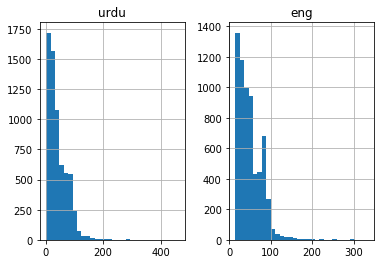

In [5]:
urdu_l = []
eng_l = []

# populate the lists with sentence lengths
for i in range(len(text_pairs)):
    urdu_l.append(len(text_pairs[i][0]))
    eng_l.append(len(text_pairs[i][1]))

length_df = pd.DataFrame({'urdu':urdu_l, 'eng':eng_l})

length_df.hist(bins = 30)
plt.show()

In [6]:
print(max(urdu_l))
max(eng_l)

462


334

Now, let's split the sentence pairs into a training set, a validation set, and a test set.

In [7]:
random.shuffle(text_pairs)
num_val_samples = int(0.1 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

6519 total pairs
5217 training pairs
651 validation pairs
651 test pairs


In [8]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [9]:
# prepare Urdu tokenizer
urdu_tokenizer = tokenization([i[0] for i in text_pairs])
urdu_vocab_size = len(urdu_tokenizer.word_index)+1

print('Urdu Vocabulary Size: %d' % urdu_vocab_size)

Urdu Vocabulary Size: 7594


In [10]:
# prepare English tokenizer
eng_tokenizer = tokenization([i[1] for i in text_pairs])
eng_vocab_size = len(eng_tokenizer.word_index)+1

print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 4141


Vectorizing the text data

In [11]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
strip_chars = strip_chars.replace(",", "")
strip_chars = strip_chars.replace(".", "")

vocab_size = 15000
sequence_length = 20
batch_size = 8


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


urd_vectorization = TextVectorization(max_tokens=eng_vocab_size, output_mode="int", 
                    output_sequence_length=max(urdu_l),)

eng_vectorization = TextVectorization(max_tokens=eng_vocab_size, output_mode="int",
                     output_sequence_length=max(urdu_l)+1,standardize=custom_standardization,)

train_urd_texts = [pair[0] for pair in train_pairs]
train_eng_texts = [pair[1] for pair in train_pairs]
urd_vectorization.adapt(train_urd_texts)
eng_vectorization.adapt(train_eng_texts)

In [12]:
print(train_pairs[:5])
print('=========================\n')
print(train_urd_texts[:5])
print('=========================\n')
train_eng_texts[:5]

[('dafa hojaona', '[start] get lost [end]'), ('seehday hath par rkho', '[start] keep to the leftright [end]'), ('france november me shandar hota he magar yay kabhi kabhi garam hota he september me', '[start] france is wonderful during november but it is sometimes hot in september [end]'), ('bohat jaldi tarseel hua aur bohat awla mayar hai', '[start] good quality and it was delivered on time [end]'), ('bura ny h iss keemat may', '[start] not bad at this price [end]')]

['dafa hojaona', 'seehday hath par rkho', 'france november me shandar hota he magar yay kabhi kabhi garam hota he september me', 'bohat jaldi tarseel hua aur bohat awla mayar hai', 'bura ny h iss keemat may']



['[start] get lost [end]',
 '[start] keep to the leftright [end]',
 '[start] france is wonderful during november but it is sometimes hot in september [end]',
 '[start] good quality and it was delivered on time [end]',
 '[start] not bad at this price [end]']

In [13]:
def format_dataset(urd, eng):
    urd = urd_vectorization(urd)
    eng = eng_vectorization(eng)
    return ({"encoder_inputs": urd, "decoder_inputs": eng[:, :-1],}, eng[:, 1:])


def make_dataset(pairs):
    urd_texts, eng_texts = zip(*pairs)
    urd_texts = list(urd_texts)
    eng_texts = list(eng_texts)
    dataset = tf.data.Dataset.from_tensor_slices((urd_texts, eng_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [14]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (8, 462)
inputs["decoder_inputs"].shape: (8, 462)
targets.shape: (8, 462)


In [15]:
inputs["encoder_inputs"][:5]


<tf.Tensor: shape=(5, 462), dtype=int64, numpy=
array([[ 346,  647, 3728, ...,    0,    0,    0],
       [ 382, 1597,    0, ...,    0,    0,    0],
       [1490,    1,    2, ...,    0,    0,    0],
       [  70,   16,    1, ...,    0,    0,    0],
       [ 713,   53,  916, ...,    0,    0,    0]])>

In [16]:
inputs["decoder_inputs"][:5]

<tf.Tensor: shape=(5, 462), dtype=int64, numpy=
array([[  2, 543, 274, ...,   0,   0,   0],
       [  2,  78, 184, ...,   0,   0,   0],
       [  2,   9, 404, ...,   0,   0,   0],
       [  2, 110, 145, ...,   0,   0,   0],
       [  2,  35,   4, ...,   0,   0,   0]])>

In [17]:
targets[:5]

<tf.Tensor: shape=(5, 462), dtype=int64, numpy=
array([[543, 274, 689, ...,   0,   0,   0],
       [ 78, 184,   3, ...,   0,   0,   0],
       [  9, 404,  15, ...,   0,   0,   0],
       [110, 145,  60, ...,   0,   0,   0],
       [ 35,   4, 182, ...,   0,   0,   0]])>

In [18]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [19]:
# embed_dim = 256
# latent_dim = 2048
# num_heads = 8

# encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
# x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
# encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
# encoder = keras.Model(encoder_inputs, encoder_outputs)

# decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
# encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
# x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
# x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
# x = layers.Dropout(0.5)(x)
# decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
# decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

# decoder_outputs = decoder([decoder_inputs, encoder_outputs])
# transformer = keras.Model(
#     [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
# )

In [20]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(max(urdu_l), urdu_vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(max(eng_l), eng_vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(eng_vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

Training our model

In [21]:
epochs = 50  # This should be at least 30 for convergence

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
plot_model(transformer, to_file='model_plot_horizontal.png', show_shapes=True, show_layer_names=True,rankdir='LR',show_layer_activations=True)
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   2062336     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[

In [22]:
transformer.save("models/transformers")

INFO:tensorflow:Assets written to: models/transformers/assets


INFO:tensorflow:Assets written to: models/transformers/assets
/home/maaz/anaconda3/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/maaz/anaconda3/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


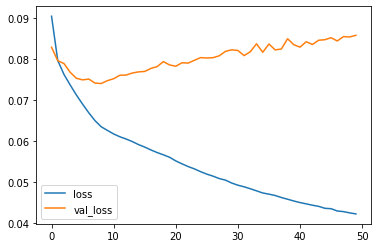

In [23]:
plt.plot(transformer.history.history['loss'])
plt.plot(transformer.history.history['val_loss'])
plt.legend(['loss','val_loss','accuracy','val_accuracy'])
plt.show()

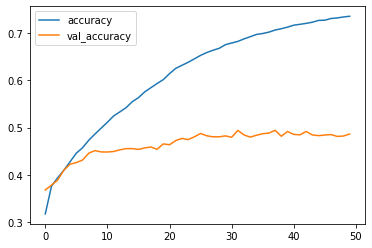

In [24]:
plt.plot(transformer.history.history['accuracy'])
plt.plot(transformer.history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.show()

Decoding test sentences

In [31]:
eng_vocab = eng_vectorization.get_vocabulary()
eng_index_lookup = dict(zip(range(len(eng_vocab)), eng_vocab))
max_decoded_sentence_length = 467


def decode_sequence(input_sentence):
    tokenized_input_sentence = urd_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = eng_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = eng_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)

In [32]:
print(input_sentence)
print("==============================================")
print(translated)

shehad ki mayar bohat awla hai qeemat bhi munasib hai
[start] got this product on time its good [end]
